## Andrii Tyvodar 50% , Šimon Podolan - 50%


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold, StratifiedShuffleSplit)
from sklearn.preprocessing import (PolynomialFeatures, LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, FunctionTransformer, OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, classification_report)
from sklearn.utils import shuffle, resample
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GroupShuffleSplit


In [2]:
train_df = pd.read_csv("train_transformed_cleaned.csv")
test_df = pd.read_csv("test_transformed_cleaned.csv")
df_merged = pd.read_csv("df_merged.csv")

## 3.1
(A-3b) Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň). (we use depth =10 )

(B-1b) Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.

(C-1b) Zístite či Váš ID3 klasifikátor má overfit.


In [3]:
# mwra to numeric
df_merged['mwra'] = df_merged['mwra'].astype(int)

# Group-Based Splitting
groups = df_merged['username']  # Use 'username' as the grouping variable

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df_merged, groups=groups))

train_df = df_merged.iloc[train_idx].copy()
test_df = df_merged.iloc[test_idx].copy()

# Verify no overlapping users
train_users = set(train_df['username'])
test_users = set(test_df['username'])
user_overlap = train_users.intersection(test_users)
print(f"Number of overlapping users after split: {len(user_overlap)}")  # Should output 0

# Convert datetime columns to numeric format
datetime_cols = ['ts', 'registration', 'birthdate']
for col in datetime_cols:
    for df in [train_df, test_df]:
        # Convert to datetime
        df[col] = pd.to_datetime(df[col], errors='coerce')

        df[col] = df[col].astype('int64') / 1e9  # Convert to seconds since epoch

        # Ensure the column is of type float64
        df[col] = df[col].astype('float64')

# Label encoding
label_columns = ['store_name', 'code', 'location', 'residence', 'company', 'ssn',
                 'name', 'mail', 'username', 'job']

label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]]).astype(str)
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le

# Feature selection and target column
target_column = 'mwra'
selected_features = [
    'p.android.gm',
    'c.android.gm',
    'c.katana',
    'c.dogalize',
    'c.android.youtube',
    'p.android.externalstorage',
    'p.android.documentsui',
]

# Ensure selected features are in the DataFrame
missing_features = [feat for feat in selected_features if feat not in train_df.columns]
if missing_features:
    print(f"The following selected features are missing from the DataFrame: {missing_features}")

# Separate features and target for training and testing
X_train = train_df[selected_features]
y_train = train_df[target_column]
X_test = test_df[selected_features]
y_test = test_df[target_column]

# Verify overlap after feature selection using indices
overlap = set(X_train.index).intersection(set(X_test.index))
print(f"Number of overlapping samples after feature selection: {len(overlap)}") 

clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Prediction on the test set
y_pred = clf.predict(X_test)

# Evaluation metrics (accuracy, precision, recall)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

# Overfitting check
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
overfit = train_accuracy > test_accuracy + 0.1  # overfit check

# Output results
evaluation_results = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy,
    "Overfit": overfit
}

# Display evaluation results
print(evaluation_results)

Number of overlapping users after split: 0
Number of overlapping samples after feature selection: 0
{'Accuracy': 0.9269810715431505, 'Precision': 0.9267826074396608, 'Recall': 0.9269810715431505, 'Train Accuracy': 0.9328488763288925, 'Test Accuracy': 0.9269810715431505, 'Overfit': False}


## 3.2
(D-1b) Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus


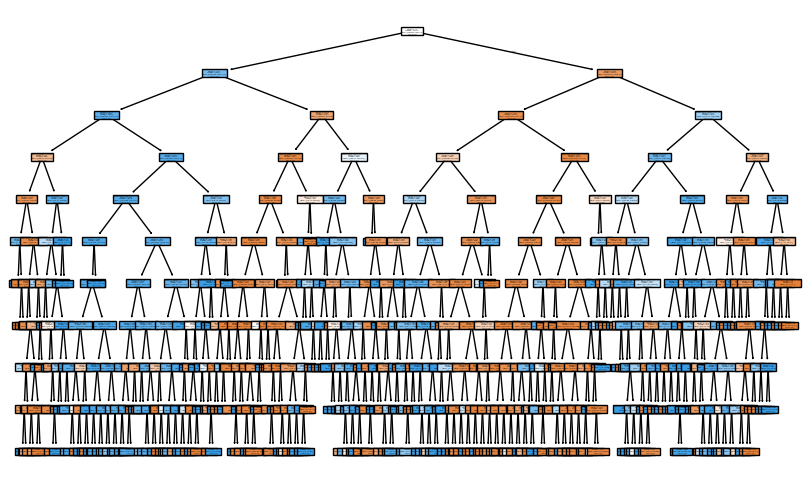

In [4]:
plt.figure(figsize=(10, 6))
plot_tree(clf, feature_names=selected_features, class_names=True, filled=True)
plt.show()

## 3.2
(A-1b) Na trénovanie využite jeden stromový algoritmus v scikit-learn.


In [5]:
# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=9,
    random_state=42,
    class_weight='balanced'
)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)

In [6]:
# Initialize the Logistic Regression Classifier
lr_clf = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)

# Train the classifier
lr_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_clf.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)

In [7]:
# ID3 Decision Tree Classifier (from previous steps)
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=9,
    random_state=42,
    class_weight='balanced'
)
clf.fit(X_train, y_train)

y_pred_id3 = clf.predict(X_test)

# Evaluate the model
accuracy_id3 = accuracy_score(y_test, y_pred_id3)
precision_id3 = precision_score(y_test, y_pred_id3, average='weighted', zero_division=0)
recall_id3 = recall_score(y_test, y_pred_id3, average='weighted', zero_division=0)

(B-1b) Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.


(C-1b) Porovnajte výsledky s ID3 z prvého kroku.

(E-1b) Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall


In [8]:
# Compile results into a DataFrame
import pandas as pd

evaluation_df = pd.DataFrame({
    'Model': ['ID3 Decision Tree', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [accuracy_id3, accuracy_rf, accuracy_lr],
    'Precision': [precision_id3, precision_rf, precision_lr],
    'Recall': [recall_id3, recall_rf, recall_lr]
})

print("\nComparison of Classifier Performance:")
print(evaluation_df)


Comparison of Classifier Performance:
                 Model  Accuracy  Precision    Recall
0    ID3 Decision Tree  0.922233   0.922101  0.922233
1        Random Forest  0.927997   0.927939  0.927997
2  Logistic Regression  0.909496   0.909164  0.909496


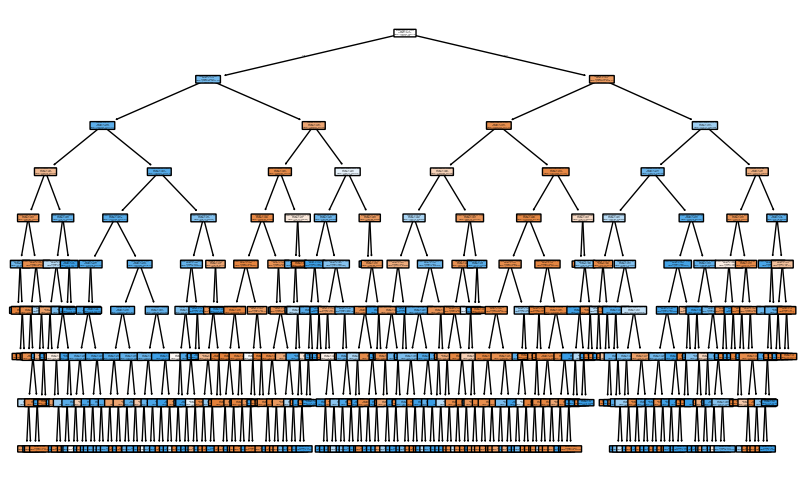

In [9]:
plt.figure(figsize=(10, 6))
plot_tree(
    clf,
    feature_names=selected_features,
    class_names=['False', 'True'],
    filled=True,
    rounded=True,
)
plt.show()

 ## Optimalizácia alias hyperparameter tuning (5b)
(A-1b) Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).

(B-1b) Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu) . 

(C-1b) Využite krížovú validáciu (cross validation) na trénovacej množine.

(D-2b) Dokážte že Váš nastavený najlepší model je bez overfitingu.

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Group-Based Splitting
groups = df_merged['username']

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df_merged, groups=groups))

train_df = df_merged.iloc[train_idx].copy()
test_df = df_merged.iloc[test_idx].copy()

# Verify no overlapping users
train_users = set(train_df['username'])
test_users = set(test_df['username'])
user_overlap = train_users.intersection(test_users)
print(f"Number of overlapping users after split: {len(user_overlap)}")

# Preprocessing
for col in ['mwra', 'IsRegistrationDefined', 'IsBirthdateDefined']:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

# Convert datetime columns
datetime_cols = ['ts', 'registration', 'birthdate']
for col in datetime_cols:
    for df in [train_df, test_df]:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].astype('int64') / 1e9
        df[col] = df[col].astype('float64')

# Label encoding
label_columns = ['store_name', 'code', 'location', 'residence', 'company', 'ssn', 'name', 'mail', 'username', 'job']
label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]]).astype(str)
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le

# Preprocessing pipelines
numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
minmax_columns = ['ts', 'imei', 'birthdate', 'registration', 'job', 'store_name', 'code', 'location', 
                  'residence', 'company', 'ssn', 'name', 'mail', 'username']
other_columns = list(set(numeric_features) - set(minmax_columns) - set(['mwra']))

pipeline_part1 = Pipeline(steps=[
    ('quantile_transform', QuantileTransformer(output_distribution='normal')), 
    ('minmax_scaler', MinMaxScaler())  
])

pipeline_part2 = Pipeline(steps=[
    ('power_transform', PowerTransformer(method='yeo-johnson')), 
    ('standard_scaler', StandardScaler()) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', pipeline_part1, minmax_columns),
        ('scaler', pipeline_part2, other_columns)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = train_df.drop(columns=['mwra'])
y_train = train_df['mwra']
X_test = test_df.drop(columns=['mwra'])
y_test = test_df['mwra']

pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Retrieve feature names
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Set up GroupKFold
gkf = GroupKFold(n_splits=5)

# Decision Tree Hyperparameter Tuning
print("Optimalizácia hyperparametrov pre Decision Tree...")
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}
grid_search_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=gkf.split(X_train_transformed, y_train, groups=train_df['username']),
    scoring='accuracy',
    n_jobs=-1
)
grid_search_dt.fit(X_train_transformed, y_train)
best_tree = grid_search_dt.best_estimator_
print(f"Najlepšie parametre Decision Tree: {grid_search_dt.best_params_}")

# Evaluate Tuned Decision Tree
y_pred_dt = best_tree.predict(X_test_transformed)
evaluate_model = lambda name, y_true, y_pred: print(
    f"{name} Model:\n  Accuracy: {accuracy_score(y_true, y_pred):.4f}\n  Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}\n  Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}\n" + "-"*30
)
evaluate_model("Tuned Decision Tree", y_test, y_pred_dt)

# Overfitting Check
train_accuracy_dt = best_tree.score(X_train_transformed, y_train)
test_accuracy_dt = accuracy_score(y_test, y_pred_dt)
overfit_dt = train_accuracy_dt > test_accuracy_dt + 0.1
print(f"Tuned Decision Tree Training Accuracy: {train_accuracy_dt:.4f}")
print(f"Tuned Decision Tree Test Accuracy: {test_accuracy_dt:.4f}")
print(f"Overfitting: {'Yes' if overfit_dt else 'No'}")

# Bagging Classifier
print("Trénovanie kombinovaných modelov...")
bagging_clf = BaggingClassifier(estimator=best_tree, n_estimators=10, random_state=42, n_jobs=-1)
bagging_clf.fit(X_train_transformed, y_train)
y_pred_bagging = bagging_clf.predict(X_test_transformed)
evaluate_model("Bagging Classifier", y_test, y_pred_bagging)

# Overfitting Check for Bagging
train_accuracy_bagging = bagging_clf.score(X_train_transformed, y_train)
test_accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
overfit_bagging = train_accuracy_bagging > test_accuracy_bagging + 0.1
print(f"Bagging Classifier Training Accuracy: {train_accuracy_bagging:.4f}")
print(f"Bagging Classifier Test Accuracy: {test_accuracy_bagging:.4f}")
print(f"Overfitting: {'Yes' if overfit_bagging else 'No'}")

# Random Forest Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

randomized_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=4, 
    cv=gkf.split(X_train_transformed, y_train, groups=train_df['username']),
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_rf.fit(X_train_transformed, y_train)
best_rf = randomized_search_rf.best_estimator_
print(f"Najlepšie parametre Random Forest: {randomized_search_rf.best_params_}")

# Evaluate Random Forest
y_pred_rf = best_rf.predict(X_test_transformed)
evaluate_model("Random Forest", y_test, y_pred_rf)

# Overfitting Check for Random Forest
train_accuracy_rf = best_rf.score(X_train_transformed, y_train)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
overfit_rf = train_accuracy_rf > test_accuracy_rf + 0.1
print(f"Random Forest Training Accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")
print(f"Overfitting: {'Yes' if overfit_rf else 'No'}")

# Cross-validation
print("\nKrížová validácia na trénovacej množine...")
cv_scores_dt = cross_val_score(
    best_tree,
    X_train_transformed,
    y_train,
    cv=gkf.split(X_train_transformed, y_train, groups=train_df['username']),
    scoring='accuracy',
    n_jobs=-1
)
cv_scores_bagging = cross_val_score(
    bagging_clf,
    X_train_transformed,
    y_train,
    cv=gkf.split(X_train_transformed, y_train, groups=train_df['username']),
    scoring='accuracy',
    n_jobs=-1
)
cv_scores_rf = cross_val_score(
    best_rf,
    X_train_transformed,
    y_train,
    cv=gkf.split(X_train_transformed, y_train, groups=train_df['username']),
    scoring='accuracy',
    n_jobs=-1
)

print(f"Tuned Decision Tree CV Accuracy: {np.mean(cv_scores_dt):.4f}")
print(f"Bagging Classifier CV Accuracy: {np.mean(cv_scores_bagging):.4f}")
print(f"Random Forest CV Accuracy: {np.mean(cv_scores_rf):.4f}")

# Final Overfitting Check
print("\nOverenie absencie overfitu...")
print(f"Tuned Decision Tree Overfit: {'No' if not overfit_dt else 'Yes'}")
print(f"Bagging Classifier Overfit: {'No' if not overfit_bagging else 'Yes'}")
print(f"Random Forest Overfit: {'No' if not overfit_rf else 'Yes'}")


Number of overlapping users after split: 0
Optimalizácia hyperparametrov pre Decision Tree...
Najlepšie parametre Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Tuned Decision Tree Model:
  Accuracy: 0.9358
  Precision: 0.9360
  Recall: 0.9358
------------------------------
Tuned Decision Tree Training Accuracy: 0.9410
Tuned Decision Tree Test Accuracy: 0.9358
Overfitting: No
Trénovanie kombinovaných modelov...
Bagging Classifier Model:
  Accuracy: 0.9401
  Precision: 0.9402
  Recall: 0.9401
------------------------------
Bagging Classifier Training Accuracy: 0.9435
Bagging Classifier Test Accuracy: 0.9401
Overfitting: No
Najlepšie parametre Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
Random Forest Model:
  Accuracy: 0.9969
  Precision: 0.9969
  Recall: 0.9969
------------------------------
Random Forest Training Accuracy: 0.9996
Random Forest Test Accuracy: 0.9969
Overfitt

In [11]:
#verifikacia mnozin
#shuffle
#oversampling/under

## 3.4

## (A-1b) Stratégie riešenia chýbajúcich hodnôt a outlierov

### In faza 1 we fix missing values and outliers. What we did: 

 for columns residence and location we drop all location with null value. and inplace all residences with null values to values of locations 

 To handle missing values in the registration and birthdate columns, we  replaced them with a midian of year month and day. Additionally, we add a new columns, IsRegistrationDefined and IsBirthdateDefined , to indicate whether the date was originally defined (0) or filled in (1). 

 Also we created class 'Not_defined' for job

 For other columns with missing values we implace it with median 

## Outliers 

### In faza 1 we implemented function 'generate_outliers' that returns a df with count of outliers in each column

 for column 'p.system' we simply remove outliers 

 for all other columns we use our function ''replace_outliers_with_boundaries'' that replaces outliers with normal values

## (B-1) Dátová transformácia (scaling, transformer, …)

### in faza 2 we did data transforming

 first of all we replace datetime values with int values. Then we applyed lable encoder for categorical values. we use min-max scaler for columns that was transformed using label encoder. also for this data we use QuantileTransformer. for all other data we use PowerTransformer and standart scaler. We decide use minmax scaler for categoricala values because after using label encoder we received very big values, so it was good approach to make them 'smaller'. 


## (C-1b) Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning

### In faza 2 we used Random forest, Lasso, corr matrix and depending on its results we choose attributes.

### Algorithms: 

 we used this algorithms for our data: ID3 Decision Tree, Random Forest, and Logistic Regression

### hyperparameter tuning

 we used GridSearchCV for Decision Tree, RandomizedSearchCV for Random Forest,

### ensemble learning

 we used BaggingClassifier and  RandomForestClassifier 

## (D-1b) Ktorý model je Váš najlepší model pre nasadenie (deployment)? 

 we can say that Random forest model has the best results but for deployment thats big accuracy is strange so for eployment i would choose Decision Tree Model.   

## (E-1b) Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?


### Summary of the Data Pipeline
 
Data Collection-> Date Transformation-> Train-Test Split->Model Training->Model Evaluation->Ensemble Learning->Cross-Validation
